# Analogies
This notebook investigates analogies between wordvectors.
As input, we use a file with embeddings generated by [embiggen](https://pypi.org/project/embiggen/]) together
with a file with the corresponding word labels.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN


The following code allows us to import the ``kcet`` module from the local repository.

In [6]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from kcet import Wordvec2Cosine

The constructor of ``Wordvec2Cosine`` loads the word embeddings and words into a pandas dataframe.

In [7]:
data_directory = 'data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df_pubmed_words = w2c.get_embeddings()
df_pubmed_words.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388


## Embeddings of 4 words ;"tamoxifen", "breast cancer", "uterine cervical cancer", "Bleomycin"

In [8]:
#"meshd013629" tamoxifen
#meshd001943 breast cancer

#meshd001761 Bleomycin
#meshd002583 uterine cervical cancer

#meshc582435, pembrolizumab
#"meshd016889" endometrial cancer,


#meshd008558 Melphalan
#meshd010051 ovarian cancer


#meshd005185 fallopian tube cancer
#meshd000068258 Bevacizumab
#meshd016190 Carboplatin
#meshd002945 cysplatine

df_words = df_pubmed_words.loc[["meshd013629", "meshd001943","meshd001761","meshd002583","meshd008558","meshd010051"]]
#df_words = df_pubmed_words.loc[["meshc582435","meshd016889","meshd001761","meshd002583","meshd008558","meshd010051"]]
#df_words = df_pubmed_words.loc[["meshd013629", "meshd001943","meshd001761","meshd002583",  "meshc582435", "meshd016889"]] 
#df_words = df_pubmed_words.loc[["meshd013629", "meshd001943", "meshd001761","meshd002583"]]
df_words = df_pubmed_words.loc[["cardiology", "smoking","dermatology","dermatologist"]]


#meshd008175 lung neoplasms 
#meshd001943 breast neoplasms
#meshd008113 liver neoplasms
#meshd010051 ovarian neoplasms
#meshd013274 stomach neoplasms
df_words = df_pubmed_words.loc[["lung", "meshd008175", "breast", "meshd001943", "ovarian", "meshd010051", "liver", "meshd008113"]]


In [9]:
df_words

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
lung,3.196993,-4.231648,1.659041,4.174098,2.751357,3.321926,-2.715797,3.439398,0.508167,-6.636255,...,-1.730516,4.045200,5.256654,-2.251897,-3.720957,5.053051,-2.156815,1.889451,0.652380,9.955623
meshd008175,3.301751,-4.811779,1.622228,3.851357,2.915498,3.848569,-1.740700,3.183929,0.596785,-5.987088,...,-2.284585,2.975377,5.520432,-2.285758,-3.951332,4.657407,-2.712857,2.580101,0.411148,8.063503
breast,2.932045,-2.258747,1.727347,3.481520,3.250926,4.625692,-3.668364,3.829142,0.252712,-6.158445,...,-1.614505,5.565101,5.280187,-3.592336,-4.315172,7.719002,-5.337784,1.534341,0.529590,9.611197
meshd001943,3.212003,-1.882929,1.929095,3.227999,3.379572,3.978704,-2.658826,4.842093,0.024247,-5.611629,...,-1.743007,3.623182,4.277930,-3.402141,-5.300494,7.399817,-6.084196,2.057205,0.085744,7.320337
ovarian,2.594003,-2.343279,2.036207,3.564083,4.282115,4.167055,-3.132109,3.102955,0.594319,-5.931544,...,-1.198288,5.747763,4.151865,-2.510381,-3.752917,6.940501,-4.859576,0.568360,0.617840,8.848403
meshd010051,3.072791,-2.909225,2.060097,4.283984,5.044001,3.521364,-2.625771,2.760182,0.359268,-5.208926,...,-2.067533,4.287587,5.239411,-2.756318,-4.954819,6.051542,-4.532008,0.841578,0.163029,7.852741
liver,3.179260,-4.553947,1.776016,3.099318,4.230488,4.222075,-3.451780,3.541979,1.000978,-5.536757,...,-0.397900,4.735034,5.977280,-2.495616,-3.424710,4.810229,-3.058471,2.407142,0.092114,10.095568
meshd008113,3.004256,-5.385717,1.737515,2.379135,3.612733,4.857090,-2.498205,2.739218,1.137355,-5.264485,...,-0.762170,4.384346,6.206931,-2.656664,-3.667631,4.676504,-2.116742,1.954225,0.480516,9.376901


# PCA visualization

In [37]:
cvec=["red","orange","blue","green","cyan","grey"]
#cvec=["red","orange","blue","green"]
cvec=["red","darkorange","blue","green","darkturquoise","dimgrey","magenta","black"]
#cvec=["red","orange","blue","green","cyan","grey","yellow","black","purple","brown"]


In [38]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_words.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.46207425 0.22171257 0.1549902 ]


Text(0, 0.5, 'PC 2 (22.17%)')

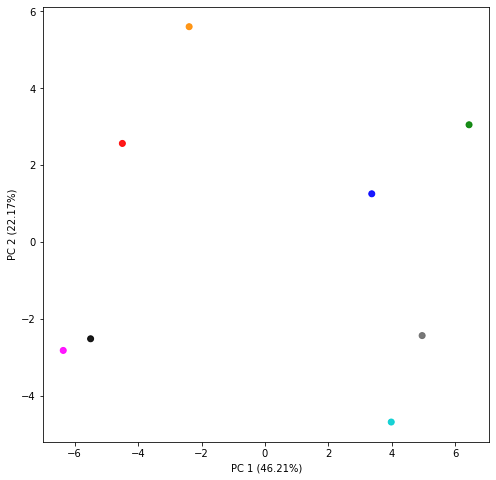

In [39]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0],pca_result[:,1] ,c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 


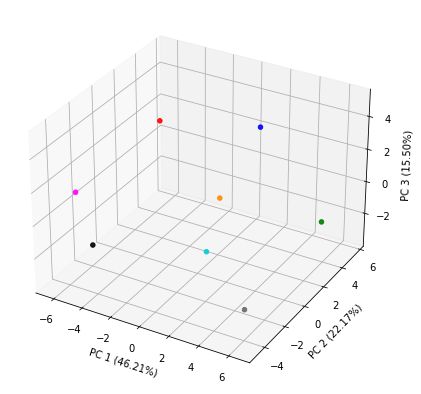

In [41]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], color = cvec,alpha=0.9)
#plt.title("3D scatter plot")
ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100)) 
ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 
ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
 
# show plot
plt.show()

# Find pairs of similar vectors for display

In [36]:
from kcet import KinasePredictor, KcetParser
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)
kcetParser = KcetParser()
id_to_symbol = kcetParser.get_id_to_symbol_map()
mesh_to_disease = kcetParser.get_mesh_to_disease_map()


[INFO] We ingested 293274 labeled word vectors from data/embeddings_final/embedding_SG_dim100_upto2020.npy and data/embeddings_final/words_SG_upto2020.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] We ingested 694 meshId/disease mappings from /home/peter/GIT/KCET/input/neoplasms_labels.tsv

[INFO] Reading protein kinase information from /home/peter/GIT/KCET/input/prot_kinase.tsv
[INFO] ingested symbol_to_id_map with 522 entries such as {'NCBIGene:2870': 'GRK6'}
[INFO] Ingested mesh_id list with 694 entries such as 'meshd000008' and 'meshd000069293', 
[INFO] Ingested _meshid2disease_map with 694 entries
[INFO] Ingested meshid2disease_map with 514 entries
[INFO] Ingested pki_to_kinase with 83 entries


In [15]:
positive_examples = os.path.join("data", "KCET_positive_2021.tsv")
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene.id"]]
positive_df = positive_df.rename(columns={"gene.id": "gene_id"})
positive_df.head()

,mesh_id,gene_id
0,meshd001943,ncbigene1019
1,meshd001943,ncbigene1021
2,meshd009396,ncbigene4921
3,meshd002289,ncbigene1956
4,meshd002289,ncbigene2064


In [16]:
diff_vectors_pos = predictor.get_disease_kinase_difference_vectors(examples=positive_df)
diff_vectors_neg = predictor.get

[INFO] Extracted 356 kinase-cancer difference vectors
[INFO]	Initial data: 510 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [17]:
diff_vectors_pos.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1019-meshd001943,-0.434411,-1.889999,0.374132,-0.120404,0.002760,-0.530017,-0.965589,-1.653457,-0.037492,1.472465,...,0.439234,0.659739,0.176268,-0.035537,0.413029,-0.436895,2.692938,-1.525303,0.981667,0.201775
ncbigene1021-meshd001943,-0.416303,-1.027129,0.444179,-0.417551,-0.427044,-0.774379,-1.043213,-1.962192,0.010902,1.493068,...,0.446101,0.331551,0.122329,0.500271,0.545721,-1.158050,2.694491,-1.975505,1.153500,-0.190905
ncbigene4921-meshd009396,-0.320539,2.757519,-0.605436,-1.536669,-1.309513,-1.312577,-0.135130,-1.203920,-1.089767,0.766937,...,1.157764,-1.533836,-1.614510,1.057073,1.145463,0.035696,1.028659,0.111672,-0.478126,-2.624450
ncbigene1956-meshd002289,-0.084595,1.102069,0.024822,-2.339737,2.436727,-0.028744,-2.907514,-0.866866,-0.147452,-0.070917,...,0.137142,1.167701,-0.929502,-1.175559,-1.213201,0.708660,-0.341512,-1.220692,0.654849,0.117270
ncbigene2064-meshd002289,-0.223574,1.767892,0.130727,-1.876922,2.132349,0.923829,-2.353677,0.099843,-0.199215,-0.756718,...,0.021830,0.665931,-1.306449,-1.768746,-1.531521,0.712855,-1.757755,-0.781523,0.483713,-0.554189


In [28]:
df_list = diff_vectors_pos.values.tolist()
df_keys = list(diff_vectors_pos.index)

In [50]:
cosine_similarities = defaultdict()
n = len(df_list)
rows = []
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        cosine_similarity = 1 - cosine(df_list[i],df_list[j])
        if cosine_similarity > 0.9:
            fields = df_keys[i].split("-")
            geneA = fields[0]
            diseaseA = fields[1]
            if not geneA in id_to_symbol:
                continue
            geneA = id_to_symbol.get(geneA)
            if not diseaseA in mesh_to_disease:
                continue
            diseaseA = mesh_to_disease.get(diseaseA)
            fields = df_keys[j].split("-")
            geneB = fields[0]
            diseaseB = fields[1]
            if not geneB in id_to_symbol:
                continue
            geneB = id_to_symbol.get(geneB)
            if not diseaseB in mesh_to_disease:
                continue
            diseaseB = mesh_to_disease.get(diseaseB)
            if geneA == geneB:
                continue
            if diseaseA == diseaseB:
                continue
            if "Neurofibrom" in diseaseA or "Neurofibrom" in diseaseB:
                continue
            d = {"geneA":geneA, "diseaseA": diseaseA, "geneB": geneB, "diseaseB":diseaseB, "similarity": cosine_similarity}
            #print("%s is to %s as %s is to %s (cosine: %f)" % (geneA, diseaseA, geneB, diseaseB, cosine_similarity))
            rows.append(d)
            
df = pd.DataFrame(rows)


In [53]:
df = df[['geneA','diseaseA','geneB','diseaseB','similarity']]
df[30:100]

,geneA,diseaseA,geneB,diseaseB,similarity
30,PDGFRB,"Leukemia, Myeloid, Chronic-Phase",FLT3,"Adenoma, Islet Cell",0.913521
31,PDGFRB,"Leukemia, Myeloid, Chronic-Phase",KDR,"Adenoma, Islet Cell",0.950261
32,PDGFRB,"Leukemia, Myeloid, Chronic-Phase",KIT,"Adenoma, Islet Cell",0.940144
33,PDGFRB,"Leukemia, Myeloid, Chronic-Phase",KDR,Gastrointestinal Neoplasms,0.907100
34,ABL1,Blast Crisis,SRC,"Leukemia, Myeloid, Chronic-Phase",0.906390
35,ABL1,Blast Crisis,MTOR,"Adenoma, Islet Cell",0.926014
36,ABL1,Blast Crisis,PDGFRA,"Leukemia, Myeloid, Chronic-Phase",0.910701
37,ABL1,Blast Crisis,PDGFRB,"Leukemia, Myeloid, Chronic-Phase",0.908758
38,ABL1,Blast Crisis,FLT3,"Adenoma, Islet Cell",0.974832
39,ABL1,Blast Crisis,KDR,"Adenoma, Islet Cell",0.930548
